In [1]:
import numpy as np
from scipy.sparse import csr_matrix
import matplotlib.pyplot as plt
from scipy import sparse
import gzip
import networkx as nx
from networkx import gnp_random_graph
from networkx import adjacency_matrix
from networkx import barabasi_albert_graph as ba
from collections import defaultdict
from random import random
from random import randint
from collections import Counter
from random import shuffle
from scipy import sparse as sp

In [2]:
def sir_network(A,I0,beta,mu,T):
    N = A.shape[0]
    S = np.zeros(T+1)
    I = np.zeros(T+1)
    R = np.zeros(T+1)

    S[0] = N-I0
    I[0] = I0    
      
    node_status = {node:{'current_status':'S', 'next_status':None} for node in range(N)}
    
    init_infected = np.random.permutation(N)[:I0]
    for node in init_infected:
        node_status[node]['current_status'] = 'I'
        
    for t in range(1,T+1):
        S[t] = S[t-1]
        I[t] = I[t-1]
        R[t] = R[t-1]
        for node in range(N):
            if node_status[node]['current_status']=='S':
                for neigh in A[node].indices:
                    if node_status[neigh]['current_status']=='I':
                        if np.random.rand()<beta:
                            node_status[node]['next_status']='I'
                            S[t] -= 1
                            I[t] += 1
                            break
            elif node_status[node]['current_status']=='I':
                if np.random.rand()<mu:
                    node_status[node]['next_status']='R'
                    R[t] += 1
                    I[t] -= 1

        for node in range(N):
            if node_status[node]['next_status']:
                node_status[node]['current_status'] = node_status[node]['next_status']
                node_status[node]['next_status'] = None
            
    return S,I,R
    

In [101]:
N = 10000
A_ba = nx.adjacency_matrix(nx.barabasi_albert_graph(N,10))
#G = gnp_random_graph(50, 0.2)
#A = nx.adjacency_matrix(G)
I0 = 10
T = 30
beta = 0.2
mu = 0.05

S_ba,I_ba,R_ba = sir_network(A_ba,I0,beta,mu,T)


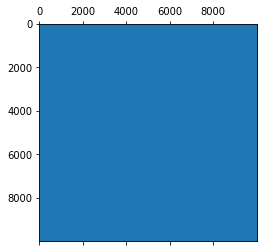

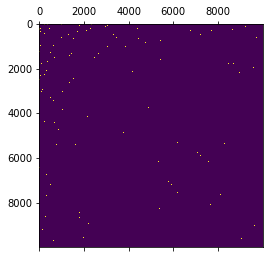

In [102]:
plt.spy(A_ba.astype(bool))
plt.matshow(A_ba.astype(bool).todense())

In [103]:
S_ba,I_ba,R_ba = sir_network(A_ba,I0,beta,mu,T)


In [104]:
def get_degrees(A, is_directed = False, degree_type = 'total'):
    if is_directed:
        if degree_type == 'total':
            degrees = np.asarray(A.sum(axis=0)).reshape(-1)
            degrees += np.asarray(A.sum(axis=1)).reshape(-1)
        elif degree_type == 'in':
            degrees = np.asarray(A.sum(axis=0)).reshape(-1) # sum over the rows
        elif degree_type == 'out':
            degrees = np.asarray(A.sum(axis=1)).reshape(-1) # sum over the columns
    else:
        degrees = np.asarray(A.sum(axis=0)).reshape(-1)
    return degrees


In [105]:
deg_ba=get_degrees(A_ba)


In [106]:
def configuration_model(degrees):
    if degrees.sum()%2 != 0:
        degrees[np.argmax(degrees)] += 1
        
    #stubs = []
    #for node, k in enumerate(degrees):
    #    stubs +=[node]*k   
    stubs = [node for node,k in enumerate(degrees) for __ in range(k)]
    shuffle(stubs)
    
    w_edges = Counter(zip(stubs[0::2],stubs[1::2]))
    nodes_i, nodes_j = zip(*w_edges.keys())
    values = list(w_edges.values())

    A = sp.csr_matrix((values*2, (nodes_i+nodes_j, nodes_j+nodes_i)))

    return A
    

In [107]:
A_config=configuration_model(deg_ba)

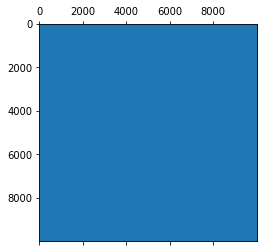

In [108]:
plt.spy(A_config.astype(bool))

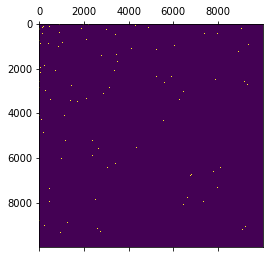

In [109]:
plt.matshow(A_config.astype(bool).todense())

In [110]:
def ER(N,p, implementation = 1, verbose = True):
    if implementation == 0:
        if verbose: print('using 2 nested for-loops')
        from random import random
        A = np.zeros((N,N))
        for row in range(N):
            for col in range(row+1,N):
                if random()<p:
                    A[row,col] = 1
                    A[col,row] = 1
    elif implementation==1:
        A = np.zeros((N,N), dtype=int)
        rows, cols = np.triu_indices(n=N,m=N,k=1)
        L = len(rows)
        rands = np.random.rand(L)        
        A[rows,cols] = rands<p
        A[cols,rows] = rands<p
    return csr_matrix(A)

In [111]:
p=sum(deg_ba)/(N*(N-1))
print(p)
A_ER=ER(N, p)

0.001998199819981998


In [112]:

deg_ER=get_degrees(A_ER)
print(sum(deg_ER))
print(sum(deg_ba))

200508
199800


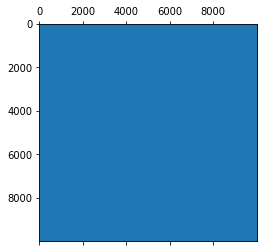

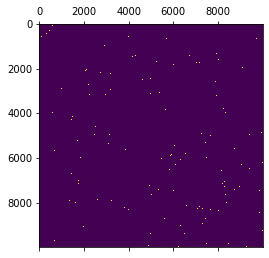

In [113]:
plt.spy(A_ER.astype(bool))

plt.matshow(A_ER.astype(bool).todense())

In [114]:
S_ER,I_ER,R_ER = sir_network(A_ER,I0,beta,mu,T)


Text(0, 0.5, 'ER model')

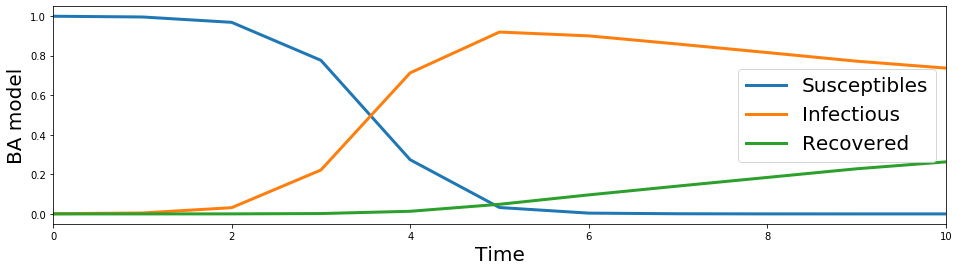

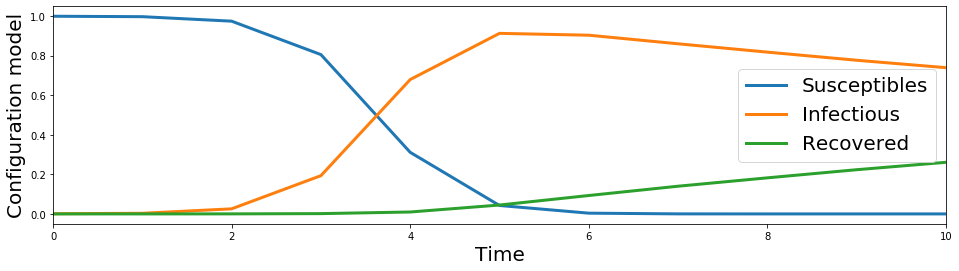

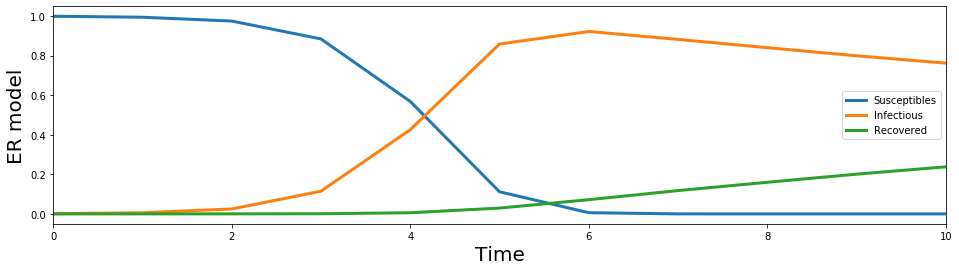

In [115]:

fig1, ax1 = plt.subplots(figsize=(16,4))
ax1.plot(S_ba/N, label='Susceptibles',lw=3)
ax1.plot(I_ba/N, label='Infectious', lw=3)
ax1.plot(R_ba/N, label='Recovered', lw=3)
ax1.legend(fontsize=20)
ax1.set_xlim(0,10)
ax1.set_xlabel('Time', fontsize=20)
ax1.set_ylabel('BA model', fontsize=20)




S_config,I_config,R_config = sir_network(A_config,I0,beta,mu,T)

fig2, ax2 = plt.subplots(figsize=(16,4))
ax2.plot(S_config/N, label='Susceptibles',lw=3)
ax2.plot(I_config/N, label='Infectious', lw=3)
ax2.plot(R_config/N, label='Recovered', lw=3)
ax2.legend(fontsize=20)
ax2.set_xlim(0,10)
ax2.set_xlabel('Time', fontsize=20)
ax2.set_ylabel('Configuration model', fontsize=20)

S_ER,I_ER,R_ER = sir_network(A_ER,I0,beta,mu,T)

fig3, ax3 = plt.subplots(figsize=(16,4))
ax3.plot(S_ER/N, label='Susceptibles',lw=3)
ax3.plot(I_ER/N, label='Infectious', lw=3)
ax3.plot(R_ER/N, label='Recovered', lw=3)
ax3.legend(fontsize=10)
ax3.set_xlim(0,10)
ax3.set_xlabel('Time', fontsize=20)
ax3.set_ylabel('ER model', fontsize=20)

In [116]:
def WattsStrogatz(N,k,p):
    if k%2 != 0:
        raise NameError('Wrong average degree')
        
    nodes = list(range(N))
    
    # This is the ring
    links = []
    for m in range(1,k//2+1):
        shifted_nodes = nodes[m:] + nodes[0:m]
        links += list(zip(nodes,shifted_nodes))
        
    from random import choice
    # Rewiring step                        
    for m in range(1,k//2+1):
        shifted_nodes = nodes[m:] + nodes[0:m]
        for node_i in nodes:
            node_j = shifted_nodes[node_i]
            if random()<p:
                rewired_node_j = choice(nodes)
                new_edge = (node_i,rewired_node_j)
                
                while (new_edge in links) or (new_edge[::-1] in links) or (rewired_node_j==node_i):
                    rewired_node_j = choice(nodes)
                    new_edge = (node_i,rewired_node_j)
                    if sum(map(lambda x:x.count(node_i),links)) == N-1:
                        print('Rewiring impossible for node: %s [edge (%s,%s)]' % (node_i, node_i, node_j))
                        break
                else:
                    # Executed only if "break" does not occur
                    links.remove((node_i,node_j))
                    links.append(new_edge)
                            
    # Fill adjacency matrix                
    rows, cols = zip(*links)
    ones = np.ones(2*len(rows))
    A = csr_matrix((ones,(rows+cols,cols+rows)), shape=(len(nodes),len(nodes)))
    return A


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


Text(0, 0.5, 'Rewiring probability 1')

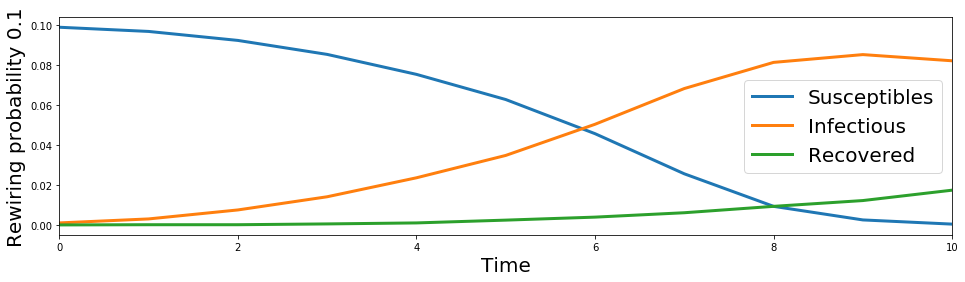

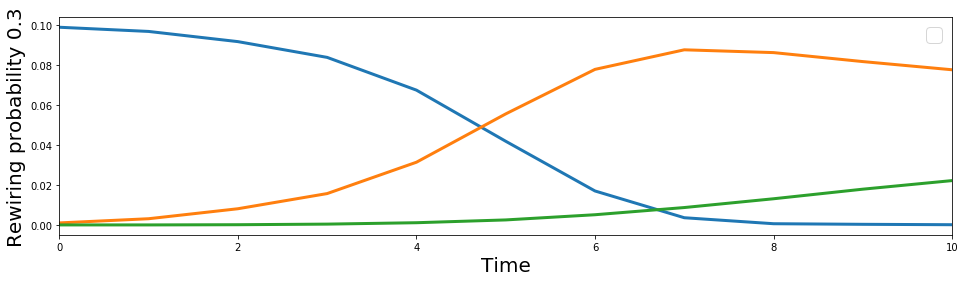

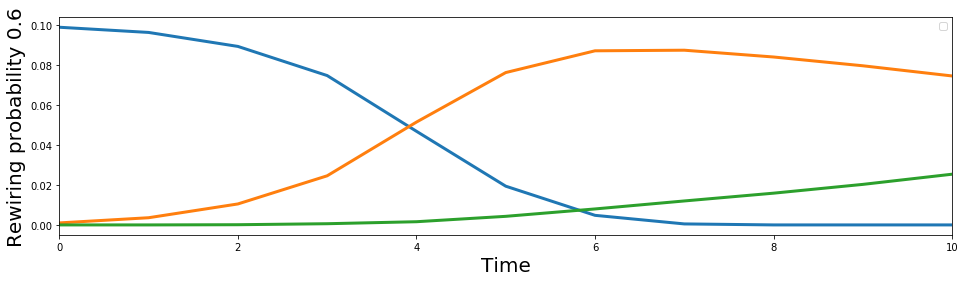

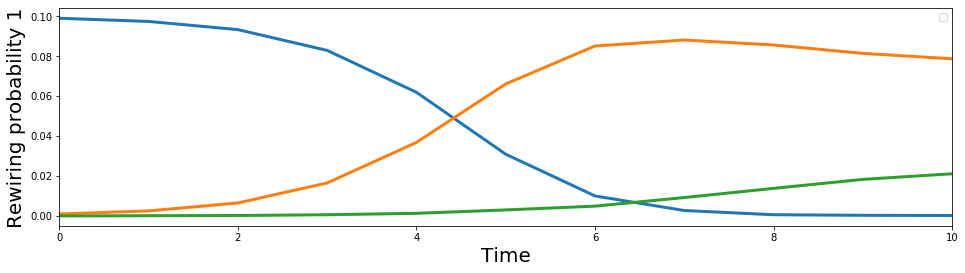

In [118]:
A_WS = WattsStrogatz(1000,10,0.1)

S_WS,I_WS,R_WS = sir_network(A_WS,I0,beta,mu,T)

fig1, ax1 = plt.subplots(figsize=(16,4))
ax1.plot(S_WS/N, label='Susceptibles',lw=3)
ax1.plot(I_WS/N, label='Infectious', lw=3)
ax1.plot(R_WS/N, label='Recovered', lw=3)
ax1.legend(fontsize=20)
ax1.set_xlim(0,10)
ax1.set_xlabel('Time', fontsize=20)
ax1.set_ylabel('Rewiring probability 0.1', fontsize=20)



A_WS = WattsStrogatz(1000,10,0.3)

S_WS,I_WS,R_WS = sir_network(A_WS,I0,beta,mu,T)

fig2, ax2 = plt.subplots(figsize=(16,4))
ax2.plot(S_WS/N,lw=3)
ax2.plot(I_WS/N, lw=3)
ax2.plot(R_WS/N, lw=3)
ax2.set_xlim(0,10)
ax2.set_xlabel('Time', fontsize=20)
ax2.set_ylabel('Rewiring probability 0.3', fontsize=20)

A_WS = WattsStrogatz(1000,10,0.6)
S_WS,I_WS,R_WS = sir_network(A_WS,I0,beta,mu,T)
fig3, ax3 = plt.subplots(figsize=(16,4))
ax3.plot(S_WS/N,lw=3)
ax3.plot(I_WS/N, lw=3)
ax3.plot(R_WS/N, lw=3)
ax3.set_xlim(0,10)
ax3.set_xlabel('Time', fontsize=20)
ax3.set_ylabel('Rewiring probability 0.6', fontsize=20)

A_WS = WattsStrogatz(1000,10,1)
S_WS,I_WS,R_WS = sir_network(A_WS,I0,beta,mu,T)
fig4, ax4 = plt.subplots(figsize=(16,4))
ax4.plot(S_WS/N,lw=3)
ax4.plot(I_WS/N, lw=3)
ax4.plot(R_WS/N, lw=3)
ax4.set_xlim(0,10)
ax4.set_xlabel('Time', fontsize=20)
ax4.set_ylabel('Rewiring probability 1', fontsize=20)

In [5]:
HierNet=nx.complete_graph(5)
HierNet.node[0]['class']='central_core'
for i in range(1,5):
    HierNet.node[i]['class']='peripheral'

for level in range(1,2):
    replicas=[HierNet.copy() for i in range(4)]
    for replica in replicas:
        replica.node[0]['class']='core'
    merge=replicas+[HierNet]   
    HierNet=nx.disjoint_union_all(merge)
    
    for node in HierNet.nodes():
        if HierNet.node[node].get('class')=='peripheral':
            HierNet.add_edge(0,node)
        

In [9]:
#